In [ ]:
### Author: Leonie Küchenhoff
### Date: October 2022
### Purpose of script: Calculate fraction of SNP per sample and tissue and categorize into type of SNP
###                     + Plot results

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy import stats
import os
from config import basedir, outdir

In [2]:
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

In [3]:
# info for saving plots data directories
os.chdir(basedir)
outdir = str(outdir + '/SNP_type/')
print('This base directory will be used:\n', basedir)  
os.chdir(basedir)

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/01_heartproject/snakemake_vcf/


In [4]:
# define filtering method
# 2ed:  Use variants that were called by 2 variant callers & have at least 5 reads in all tissues & have at least 2 alternative allels called across all tissues
filter = '2ed'
names = ['279', '282', '450']
groups = ['somatic', 'germline']
col1 = 'ad_h'
col2 = 'ad_l'
col3 = 'ad_t'

In [5]:
# paths to input files
paths_som = [f'merged/txt_files/ad_hc_mu/HLT{i}.specific.txt' for i in names]
paths_germ = [f'merged/txt_files/ad_hc_mu/HLT{i}.tisoverlap.txt' for i in names]

In [6]:
# read in data and save in dictionary format for easy accessing throughout the script
somatic_dict = {}
germline_dict = {}
for i in zip(paths_som, paths_germ, names):
    som = pd.read_csv(i[0], delimiter = '\t')
    germ = pd.read_csv(i[1], delimiter = '\t')
    somatic_dict[i[2]] = som
    germline_dict[i[2]] = germ

In [7]:
def get_snp(df):
    '''
    function to extract all variants that are snps 
    (both reference and alternative are of length 1)
    input: variant df with ref and alt column
    output: variant df with all columns with snp
    '''
    ref = df['ref'].str.len()
    alt = df['alt'].str.len()
    snp = ((ref == 1) & (alt == 1))
    snp_df = df[snp]
    return snp_df

In [8]:
def snp_stats_table(df):
    '''
    function to get the summary statistics on which snps
    were measured how many times
    '''

    df_c = df.copy()
    #get one filed with ref and alt for easier handling
    df_c.loc[:,'replacement'] = df_c['ref'] + df_c['alt']

    # group each snp with its reverse snp
    df_c.loc[df_c['replacement'] == 'GA', 'replacement'] = 'CT'
    df_c.loc[df_c['replacement'] == 'GT', 'replacement'] = 'CA'
    df_c.loc[df_c['replacement'] == 'GC', 'replacement'] = 'CG'
    df_c.loc[df_c['replacement'] == 'AT', 'replacement'] = 'TA'
    df_c.loc[df_c['replacement'] == 'AG', 'replacement'] = 'TC'
    df_c.loc[df_c['replacement'] == 'AC', 'replacement'] = 'TG'


    # count snps per sample & separate tissues
    heart_spec = df_c[df_c['heart']]
    liver_spec = df_c[df_c['liver']]
    tail_spec = df_c[df_c['tail']]
    
    heartcount = heart_spec.groupby('replacement').count()['heart']
    livercount = liver_spec.groupby('replacement').count()['liver']
    tailcount = tail_spec.groupby('replacement').count()['tail']

    # summarize snp counts into one table (can only merge two tables at once, hence merge in two steps)
    summary = pd.merge(heartcount, livercount, how = 'outer', left_index= True, right_index = True)
    summary = pd.merge(summary, tailcount, how = 'outer', left_index= True, right_index = True)

    # caluclate relative contributions per snp for each sample
    fractions = summary.div(summary.sum(axis=0), axis=1)

    # reformat table for easier plotting
    fractions['bases'] = fractions.index

    # rename columns for plot
    fractions.loc[fractions['bases'] == 'CA', 'bases']= f'C>A\nG>T'
    fractions.loc[fractions['bases'] == 'CG', 'bases']= f'C>G\nG>C'
    fractions.loc[fractions['bases'] == 'CT', 'bases']= f'C>T\nG>A'
    fractions.loc[fractions['bases'] == 'TA', 'bases']= f'T>A\nA>T'
    fractions.loc[fractions['bases'] == 'TC', 'bases']= f'T>C\nA>G'
    fractions.loc[fractions['bases'] == 'TG', 'bases']= f'T>G\nA>C'

    # reformat table for easier plotting
    fractions_plot = pd.melt(fractions, id_vars=['bases'])

    return fractions_plot, summary

In [9]:

def snp_stats_table_germ(germ):
    '''
    function to get the summary statistics on 
    which snps were measured how many times
    '''
    df_germ = germ.copy()

    #get one df with ref and alt for easier handling
    df_germ.loc[:,'replacement'] = df_germ['ref'] + df_germ['alt']
    # group each snp with its reverse snp
    df_germ.loc[df_germ['replacement'] == 'GA', 'replacement'] = 'CT'
    df_germ.loc[df_germ['replacement'] == 'GT', 'replacement'] = 'CA'
    df_germ.loc[df_germ['replacement'] == 'GC', 'replacement'] = 'CG'
    df_germ.loc[df_germ['replacement'] == 'AT', 'replacement'] = 'TA'
    df_germ.loc[df_germ['replacement'] == 'AG', 'replacement'] = 'TC'
    df_germ.loc[df_germ['replacement'] == 'AC', 'replacement'] = 'TG'
    
    # count types in germline variant files (colums used here are of no meaning)
    germcount_three = df_germ.groupby('replacement').count()['pos']

    fractions = germcount_three.to_frame().div(germcount_three.to_frame().sum(axis=0), axis=1)
    # reformat table for easier plotting
    fractions['bases'] = fractions.index

    # rename columns for plot
    fractions.loc[fractions['bases'] == 'CA', 'bases']= f'C>A\nG>T'
    fractions.loc[fractions['bases'] == 'CG', 'bases']= f'C>G\nG>C'
    fractions.loc[fractions['bases'] == 'CT', 'bases']= f'C>T\nG>A'
    fractions.loc[fractions['bases'] == 'TA', 'bases']= f'T>A\nA>T'
    fractions.loc[fractions['bases'] == 'TC', 'bases']= f'T>C\nA>G'
    fractions.loc[fractions['bases'] == 'TG', 'bases']= f'T>G\nA>C'

    # reformat table for easier plotting
    fractions_plot = pd.melt(fractions, id_vars=['bases'])
    fractions_plot.loc[fractions_plot['variable'] == 'pos','variable'] = 'tis. overlap'
    return fractions_plot, germcount_three

In [10]:
# calculate fractions and strore results in shape of dictionary
snp_dict = {}
fractions_dict = {}
fractions_dict_germ = {}
summary_dict = {}
summary_dict_germ = {}
for i in names:
    snp_dict[f'{i}_germ'] = get_snp(germline_dict[i][(germline_dict[i]['chr'] != 'chrX') & (germline_dict[i]['chr'] != 'chrY')])
    snp_dict[f'{i}_som'] = get_snp(somatic_dict[i][(somatic_dict[i]['chr'] != 'chrX') & (somatic_dict[i]['chr'] != 'chrY')])

    fractions_dict[i], summary_dict[i] = snp_stats_table(snp_dict[f'{i}_som'])
    fractions_dict_germ[i], summary_dict_germ[i] = snp_stats_table_germ(germ = snp_dict[f'{i}_germ'])

In [11]:
#plotting settings
colors = [sns.color_palette('colorblind')[3],
          sns.color_palette('colorblind')[2],
          sns.color_palette('colorblind')[0],
          'white',
          sns.color_palette('colorblind')[7]]
costum_palette = sns.color_palette(colors)

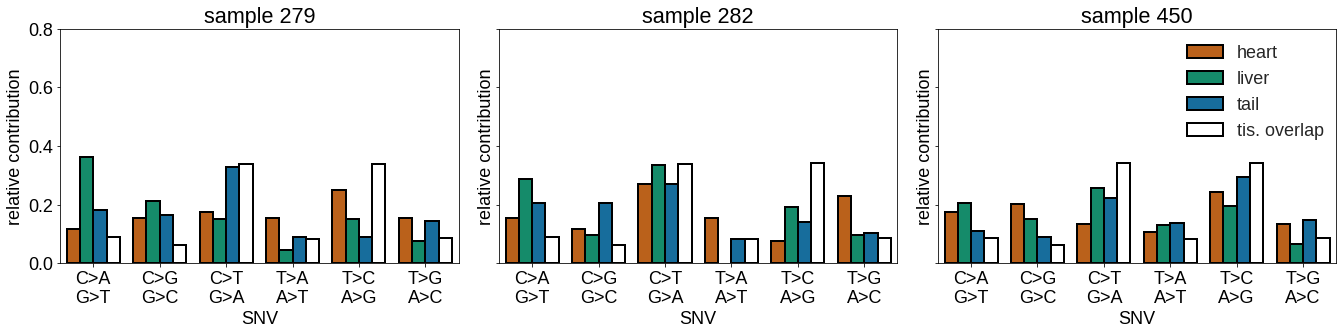

In [12]:
# Plot samples separately

fig, ax = plt.subplots(1,3, figsize = (19,5), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

for count, i in enumerate(names):
    subset = fractions_dict[i][fractions_dict[i]['variable'].isin(['heart', 'liver', 'tail', 'heart & liver'])]
    fractions_stats = pd.concat([subset, fractions_dict_germ[i]])
    fractions_stats = fractions_stats[fractions_stats['variable'].isin(['heart', 'liver', 'heart & liver', 'tail', 'tis. overlap'])]
    sns.barplot(x = 'bases',y = 'value', hue = 'variable', ax = ax[count], data = fractions_stats, 
                palette = costum_palette, edgecolor = 'black', linewidth = 2, order = [f'C>A\nG>T', f'C>G\nG>C',f'C>T\nG>A',f'T>A\nA>T',f'T>C\nA>G',f'T>G\nA>C'])
    ax[count].set_xlabel('SNV')
    ax[count].set_ylabel('relative contribution')
    ax[count].set_title(f'sample {i}')
    ax[count].set_ylim(0,0.8)
ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].legend(bbox_to_anchor = (1.01,1))
fig.tight_layout()
plt.show()

#save plot and plotted data in table

#fig.savefig(f'{outdir}/variant_type_barplot/filter2ad/snp_fractions_somaticvsgermline_filter{filter}_all.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/variant_type_barplot/filter2ad/snp_fractions_somaticvsgermline_filter{filter}_all.svg', bbox_inches = 'tight')

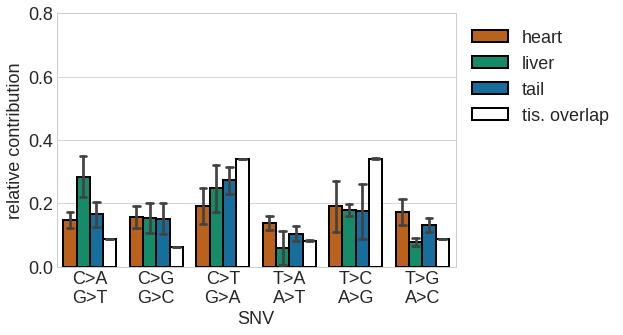

In [13]:
# Plot samples in one plot

fractions_stats = pd.concat([fractions_dict['279'], fractions_dict['282'],fractions_dict['450']], keys = ['279', '282', '450', 'germline'])
subset = fractions_stats[fractions_stats['variable'].isin(['heart', 'liver', 'tail', 'heart & liver'])]

fractions_stats = pd.concat([fractions_dict_germ['279'], fractions_dict_germ['282'],fractions_dict_germ['450']], keys = ['279', '282', '450', 'germline'])
plot = pd.concat([subset, fractions_stats])
plot = plot[plot['variable'].isin(['heart', 'liver', 'tail', 'tis. overlap'])].fillna(0)

fig, ax = plt.subplots(1,1, figsize = (9,5), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = 'bases',y = 'value', hue = 'variable', data = plot, capsize = 0.1, ci = 'sd', 
            palette = costum_palette, edgecolor = 'black', linewidth = 2, order = [f'C>A\nG>T', f'C>G\nG>C',f'C>T\nG>A',f'T>A\nA>T',f'T>C\nA>G',f'T>G\nA>C'])


ax.set_xlabel('SNV')
ax.set_ylabel('relative contribution')
#ax.set_title(f'SNVs')
ax.set_ylim(0,0.8)
ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
fig.tight_layout()
plt.show()

#save plot and plotted data in table

#fig.savefig(f'{outdir}/variant_type_barplot/filter2ad/snp_fractions_somaticvsgermline_filter{filter}_sd.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/variant_type_barplot/filter2ad/snp_fractions_somaticvsgermline_filter{filter}_sd.svg', bbox_inches = 'tight')
#plot.rename(columns = {'variable':'tissue', 'value':'proportion_per_sample_and_tissue'}).to_csv(f'{outdir}/variant_type_barplot/filter2ad/{filter}_table.csv', index_label = ['sample', 'index'])

In [14]:
# summarize data in one table
summary = summary_dict['279'].fillna(0) + summary_dict['282'].fillna(0) + summary_dict['450'].fillna(0)
summary_germ = summary_dict_germ['279'].fillna(0) + summary_dict_germ['282'].fillna(0) + summary_dict_germ['450'].fillna(0)

In [15]:
# save raw data in absoulte numvers
for i in names:
    save = summary_dict[i].fillna(0)
    save = pd.merge(save, summary_dict_germ[i], how = 'outer', left_index = True, right_index = True).rename(columns = {'alt': 'heart & liver', 'pos':'tis. overlap'})
    #save.to_csv(f'{outdir}/variant_type_barplot/filter2ad/{i}_absolute_numbers.txt', sep = '\t', index = True)

In [21]:
# test significance and save significant pairs in list

test = plot.reset_index()
grouped = test.groupby(['bases','variable'])
loc_dict = {}
for j in [f'C>A\nG>T',f'C>G\nG>C',f'C>T\nG>A',f'T>A\nA>T',f'T>C\nA>G',f'T>G\nA>C']:
    fractions = np.zeros((6, 3))
    for count,i in enumerate(['heart','liver','tail','tis. overlap']):
        fractions[count] = grouped.get_group((j , i))['value']
    loc_dict[j] = fractions
pvalue_dict = {}
for x in [f'C>A\nG>T',f'C>G\nG>C',f'C>T\nG>A',f'T>A\nA>T',f'T>C\nA>G',f'T>G\nA>C']:
    p_values = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            p_values[i,j] = stats.ttest_ind(a = loc_dict[x][i], b = loc_dict[x][j], equal_var = False)[1]
    pvalue_dict[x] = p_values
name_dict = {}
for count,i in enumerate(['heart','liver','tail','tis. overlap']):
    name_dict[count] = i

list = []

for key, i in  pvalue_dict.items():
    row, col = np.where(i<0.05)
    orderd_indexlist = []
    for i in zip(row, col):
        first = (np.array(i).min())
        second = (np.array(i).max())
        orderd_indexlist +=[(first,second)]
    for x,y in np.unique(np.array(orderd_indexlist), axis = 0):
            list += [((key, name_dict[x]), (key, name_dict[y]))]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

T>G
A>C_liver vs. T>G
A>C_tail: Welch's t-test independent samples, P_val:4.857e-02 t=-3.059e+00
T>C
A>G_liver vs. T>C
A>G_tis. overlap: Welch's t-test independent samples, P_val:6.761e-03 t=-1.197e+01


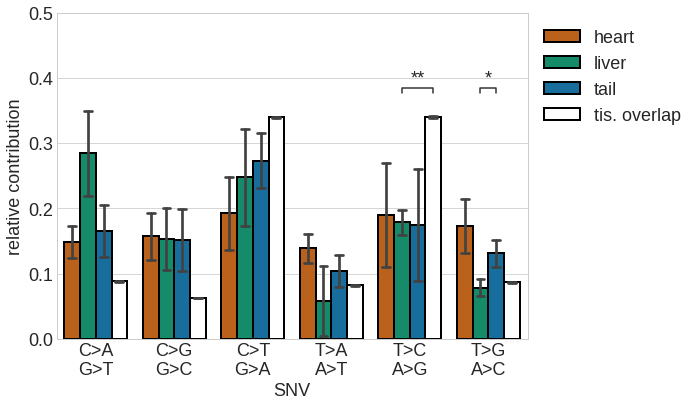

In [20]:
# Add significance asterics to plot
fig, ax = plt.subplots(1,1, figsize = (10,6), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = 'bases',y = 'value', hue = 'variable', data = plot, capsize = 0.1, ci = 'sd', 
            palette = costum_palette, edgecolor = 'black', linewidth = 2)

pairs = list
annot = Annotator(None, pairs)

annot.new_plot(ax, x = 'bases',y = 'value', hue = 'variable', data = plot, seed=2021)
annot.configure(test='t-test_welch', text_format='star', loc='outside',verbose=2)
annot.apply_test().annotate()

ax.set_xlabel('SNV')
ax.set_ylabel('relative contribution')
ax.set_ylim(0,0.5)
ax.legend(bbox_to_anchor = (1.0, 1))
fig.tight_layout()
plt.show()

#save plot

#fig.savefig(f'{outdir}/variant_type_barplot/snp_fractions_somaticvsgermline_filter{filter}_all_sd_ttest.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/variant_type_barplot/snp_fractions_somaticvsgermline_filter{filter}_all_sd_ttest.svg', bbox_inches = 'tight')